# Benchmark with the Bursi dataset

In [1]:
%matplotlib inline
%load_ext memory_profiler
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LSHForest
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import neighborsMinHash as kneighbors
from neighborsMinHash.util import create_dataset
from neighborsMinHash.util import create_dataset_fixed_nonzero
from neighborsMinHash.util import measure_performance
from neighborsMinHash.util import plotData
from neighborsMinHash.util import accuracy_and_time



import random

from scipy.sparse import dok_matrix
from scipy.sparse import rand
from scipy.sparse import vstack

from sklearn.random_projection import SparseRandomProjection

# import pyflann
import annoy

In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
%time %memit datasetBursi = vectorizer.transform( graphs )

peak memory: 276.14 MiB, increment: 183.98 MiB
CPU times: user 27.4 s, sys: 220 ms, total: 27.6 s
Wall time: 28.3 s


Computed on Intel i5-5200U 2.2 GHz, 8 GB RAM, Ubuntu Linux 14.04

In [3]:
n_neighbors_sklearn = 5
n_neighbors_minHash = 5
returnValuesBursi = measure_performance(datasetBursi, n_neighbors_sklearn, n_neighbors_minHash, 
                                        number_of_hashfunctions=[100, 200, 400, 600, 800, 32000])

#### Query time: Perform one time 50 queries at once

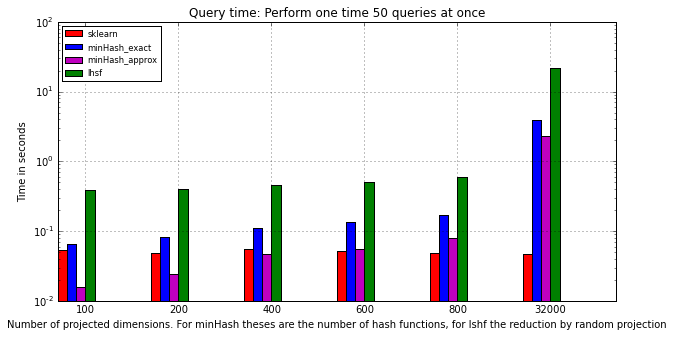

In [4]:
plotData(data=returnValuesBursi[9:13], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=["100", "200", "400", "600", "800", "32000"], ylabel="Time in seconds", number_of_instances=6,
        xlabel="Number of projected dimensions. For minHash theses are the number of hash functions, for lshf the reduction by random projection",
         number_of_features=1, title='Query time: Perform one time 50 queries at once')

#### Query time: performe 50 times one query

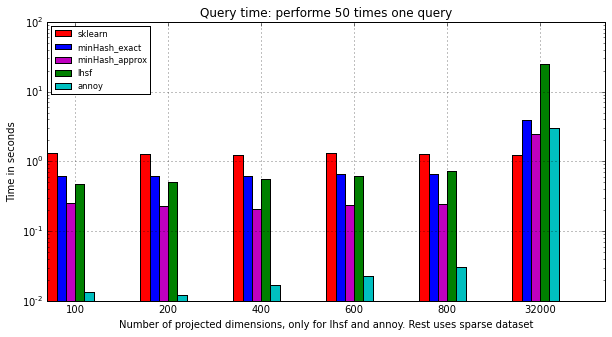

In [5]:
plotData(data=returnValuesBursi[4:9], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "32000"], ylabel="Time in seconds", 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         number_of_instances=6,
        number_of_features=1, title='Query time: performe 50 times one query')

#### Accuracy for bursi dataset

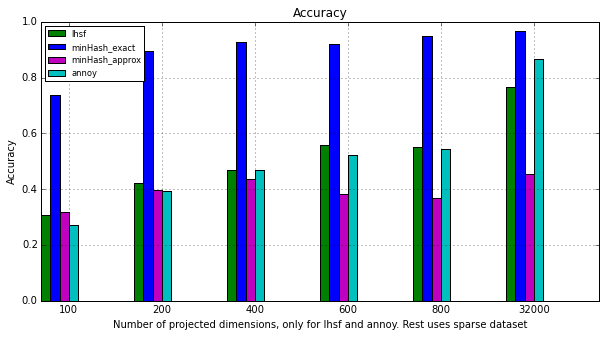

In [6]:
plotData(data=returnValuesBursi[13:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["100", "200", "400", "600", "800", "32000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Accuracy", number_of_instances=6,
        number_of_features=1, title='Accuracy', log=False)

#### Fitting time

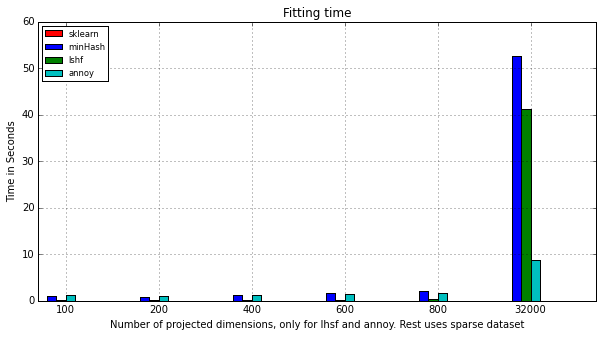

In [7]:
plotData(data=returnValuesBursi[:4], color=["r", "b", "g", "c"], label=["sklearn", "minHash", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "32000"], 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Time in Seconds", number_of_instances=6,
        number_of_features=1, title='Fitting time', log=False)

In [3]:
n_neighbors_sklearn = 5
n_neighbors_minHash = 5
returnValuesBursi = measure_performance(datasetBursi, n_neighbors_sklearn, n_neighbors_minHash, 
                                        number_of_hashfunctions=[100, 200, 400, 600, 800, 1000],
                                        size_of_query=4338)

KeyboardInterrupt: 

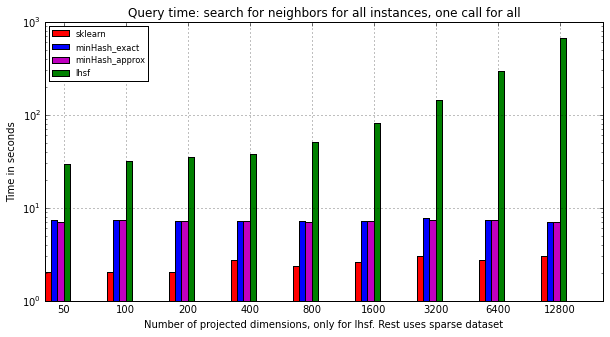

In [10]:
plotData(data=returnValuesBursi[9:13], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=["100", "200", "400", "600", "800", "1000"], ylabel="Time in seconds", number_of_instances=9,
        xlabel="Number of projected dimensions, only for lhsf. Rest uses sparse dataset",
         number_of_features=1, title='Query time: search for neighbors for all instances, one call for all')

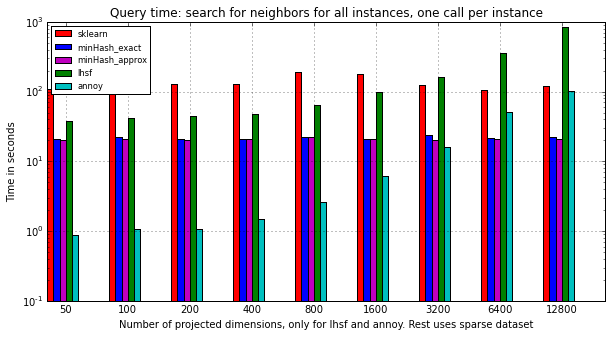

In [11]:
plotData(data=returnValuesBursi[4:9], color=["r", "b", "m", "g", "c"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"], ylabel="Time in seconds", 
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset", number_of_instances=9,
        number_of_features=1, title='Query time: search for neighbors for all instances, one call per instance')

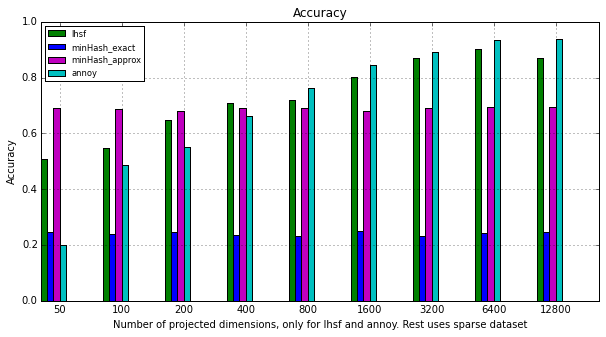

In [12]:
plotData(data=returnValuesBursi[13:], color=["g", "b", "m", "c"], label=["lhsf", "minHash_exact", "minHash_approx", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Accuracy", number_of_instances=9,
        number_of_features=1, title='Accuracy', log=False)

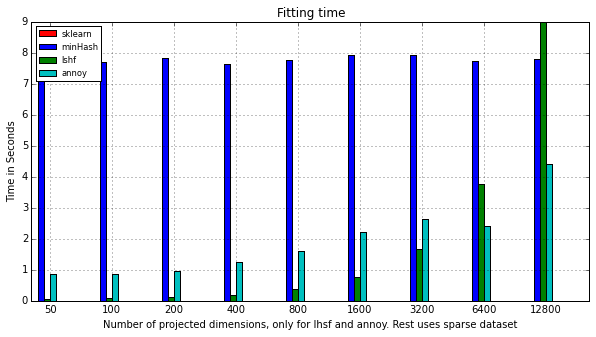

In [13]:
plotData(data=returnValuesBursi[:4], color=["r", "b", "g", "c"], label=["sklearn", "minHash", "lshf", "annoy"],
        xticks=["100", "200", "400", "600", "800", "1000"],
         xlabel="Number of projected dimensions, only for lhsf and annoy. Rest uses sparse dataset",
         ylabel="Time in Seconds", number_of_instances=9,
        number_of_features=1, title='Fitting time', log=False)

#### Fit and kneighbors vs. fit_kneighbors

In [16]:
import neighborsMinHash



time_fit_and_kneighbors = []
time_fit_kneighbors = []
for i in xrange(10):
    minHash_fit_and_kneighbors = neighborsMinHash.MinHashNearestNeighbors(n_neighbors = 5)
    minHash_fit_kneighbors = neighborsMinHash.MinHashNearestNeighbors(n_neighbors = 5)
    
    time_start = time.time()
    minHash_fit_and_kneighbors.fit(datasetBursi)
    minHash_fit_and_kneighbors.kneighbors()
    time_end = time.time()
    time_fit_and_kneighbors.append(time_end-time_start)
    
    time_start = time.time()
    minHash_fit_kneighbors.fit_kneighbors(datasetBursi)
    time_end = time.time()
    time_fit_kneighbors.append(time_end-time_start)

time_fit_and_kneighbors_mean = np.mean(time_fit_and_kneighbors)
time_fit_kneighbors_mean = np.mean(time_fit_kneighbors)
time_fit_and_kneighbors_standard_deviation = np.std(time_fit_and_kneighbors)
time_fit_kneighbors_standard_deviation = np.std(time_fit_kneighbors)



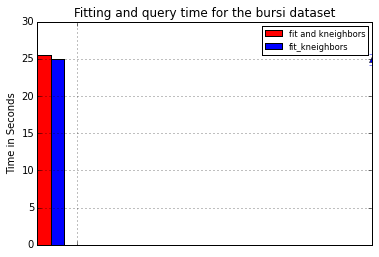

In [21]:
import matplotlib.pyplot as plt
data = [[time_fit_and_kneighbors_mean], [time_fit_kneighbors_mean]]
color=["r", "b"]
label=["fit and kneighbors", "fit_kneighbors"]
xticks=[]
xlabel=""
ylabel="Time in Seconds"
title='Fitting and query time for the bursi dataset'
log=False
figure_size=(10,2)
bar_width=1

ind = np.arange(1)    # the x locations for the groups
    
    #"r", "b", "g", "c", "m", "y", "k", "w"
count = 0
for d, c, l in zip(data, color, label):
    plt.bar(ind + count * bar_width , d,   bar_width, color=c, label=l)
    count += 1
if log:
    plt.yscale('log')
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title)
plt.xticks(ind+3*bar_width, (xticks))
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)

plt.errorbar(time_fit_and_kneighbors_mean, time_fit_kneighbors_mean, time_fit_and_kneighbors_standard_deviation, linestyle='None', marker='^')
plt.show()

#### Accuracy vs. number of hash functions
Computed on Intel i7-3770 3.4 GHz, Ubuntu Linux 14.04

In [ ]:
precision_minHash_exact = []
precision_minHash_approx = []
time_minHash_exact = []
time_minHash_approx = []
time_minHash_fit = []
size_of_query = 1000
query = None


if size_of_query < datasetBursi.shape[0]:
    query_ids = []
    for i in range(size_of_query):
        query_ids.append(random.randint(0, datasetBursi.shape[0]-1))
    query = datasetBursi[query_ids]
else:
    query = datasetBursi
nearest_neighbor_sklearn = NearestNeighbors(n_neighbors = 5)
nearest_neighbor_sklearn.fit(datasetBursi)
n_neighbors_sklearn = nearest_neighbor_sklearn.kneighbors(X=query,return_distance=False)

hash_functions_list = [50, 100, 200, 400, 800, 1000, 2000, 4000, 8000]
for hash_functions in hash_functions_list:    

    nearest_neighbor_minHash = kneighbors.MinHash(n_neighbors = 5,
                                                                  number_of_hash_functions=hash_functions,
                                                                  max_bin_size = 50, minimal_blocks_in_common = 1, 
                                                                  shingle_size = 4, excess_factor = 5,)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    # print nearest_neighbor_minHash._inverseIndex._inverse_index
    time_end = time.time()
    time_minHash_fit.append(time_end - time_start)

    time_start = time.time()
    n_neighbors_minHash_exact = nearest_neighbor_minHash.kneighbors(X=query,return_distance=False)
    time_end = time.time()
    time_minHash_exact.append(time_end - time_start)


    time_start = time.time()
    n_neighbors_minHash_approx = nearest_neighbor_minHash.kneighbors(X=query,fast=True,return_distance=False)
    # print n_neighbors_minHash_approx_1_50
    time_end = time.time()
    time_minHash_approx.append(time_end - time_start)

    accuracy_minHash_exact = np.in1d(n_neighbors_minHash_exact, n_neighbors_sklearn).mean()
    accuracy_minHash_approx = np.in1d(n_neighbors_minHash_approx, n_neighbors_sklearn).mean()
    precision_minHash_exact.append(accuracy_minHash_exact)
    precision_minHash_approx.append(accuracy_minHash_approx)
   
xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

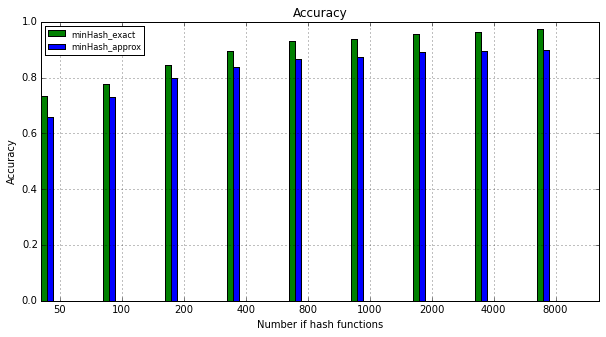

In [23]:
plotData(data=[precision_minHash_exact, precision_minHash_approx], color=["g", "b"], label=["minHash_exact", "minHash_approx"],
        xticks=xticksBursi, ylabel="Accuracy", xlabel="Number if hash functions",number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Accuracy', log=False)

#### Test the fitting time of single-core vs. multi-core for different number of hash functions
As a dataset "bursi" is used.

In [24]:
import multiprocessing as mp
time_fit = []
time_fit_single_core = []
hash_functions_list = [100, 400, 600, 800, 1000]
for hash_functions in hash_functions_list:    

    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions, number_of_cores = mp.cpu_count())
    nearest_neighbor_minHash_single_core = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions, number_of_cores=1)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    time_end = time.time()
    time_fit.append(time_end - time_start)
    
    time_start = time.time()
    nearest_neighbor_minHash_single_core.fit(datasetBursi)
    time_end = time.time()
    time_fit_single_core.append(time_end - time_start)

xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

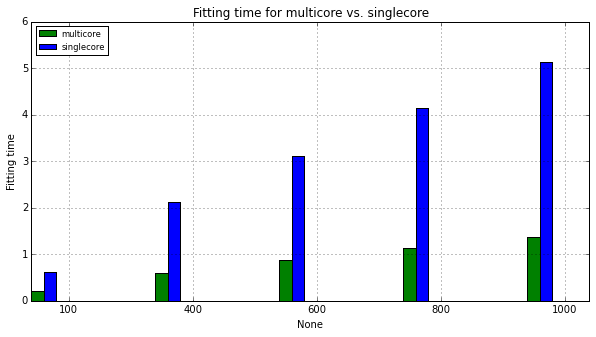

In [25]:
plotData(data=[time_fit, time_fit_single_core], color=["g", "b"], label=["multicore", "singlecore"],
        xticks=xticksBursi, ylabel="Fitting time", number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Fitting time for multicore vs. singlecore', log=False)

#### Test the fitting time of single-core vs. multi-core for datasets with different number of instances

In [2]:
import multiprocessing as mp

time_fit = []
time_fit_single_core = []
instances = [100,1000,10000, 100000, 1000000, 10000000]

for instances_ in instances:    
    X, _ = create_dataset(seed=1,
                   number_of_centroids=7,
                   number_of_instances=instances_,
                   number_of_features=100,
                   size_of_dataset=8,
                   density=0.00001,
                   fraction_of_density=0.2
                   )
    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(number_of_cores = mp.cpu_count())
    nearest_neighbor_minHash_single_core = kneighbors.MinHashNearestNeighbors(number_of_cores=1)

    time_start = time.time()
    nearest_neighbor_minHash.fit(X)
    time_end = time.time()
    time_fit.append(time_end - time_start)
    
    time_start = time.time()
    nearest_neighbor_minHash_single_core.fit(X)
    time_end = time.time()
    time_fit_single_core.append(time_end - time_start)
xticksBursi = []
for i in instances:
    xticksBursi.append(str(i))

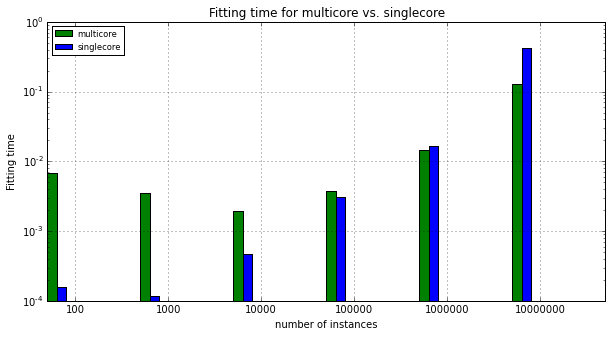

In [3]:
plotData(data=[time_fit, time_fit_single_core], color=["g", "b"], label=["multicore", "singlecore"],
        xticks=xticksBursi, ylabel="Fitting time", number_of_instances=len(instances),
        number_of_features=1, title='Fitting time for multicore vs. singlecore', xlabel="number of instances", log=True)

In [4]:
from sklearn.neighbors import NearestNeighbors
from neighborsMinHash import MinHash
from sklearn.metrics import accuracy_score
from neighborsMinHash.util import accuracy

minHashUnorderedMap = MinHash(number_of_hash_functions=400,shingle_size = 2, similarity=True, bloomierFilter=False, number_of_cores=2)
minHashBloomierFilter = MinHash(number_of_hash_functions=400,shingle_size = 2, similarity=True, bloomierFilter=True, number_of_cores=2)
neighborsSklearn = NearestNeighbors(n_jobs=2);

print "Fitting:"
print "MinHash with an unordered_map:"
%time %memit minHashUnorderedMap.fit(datasetBursi)
print "\n"
print "MinHash with the bloomier filter:"
%time %memit minHashBloomierFilter.fit(datasetBursi)
print "\n"
print "Sklearn's nearest neighbor implementation: "
%time %memit neighborsSklearn.fit(datasetBursi)
print "\n\n"
print "Computing the nearest neighbors:"
print "MinHash with an unordered_map, non fast:"
%time %memit kneighborsUnorderedMap = minHashUnorderedMap.kneighbors(n_neighbors=5, return_distance=False, fast=False)
print "\n"
print "MinHash with the bloomier filter, non fast:"
%time %memit kneighborsBloomierFilter = minHashBloomierFilter.kneighbors(n_neighbors=5, return_distance=False, fast=False)

print  "\n\n"
print "MinHash with an unordered_map, fast:"
%time %memit kneighborsUnorderedMapFast = minHashUnorderedMap.kneighbors(n_neighbors=5, return_distance=False, fast=True)
print "\n"
print "MinHash with the bloomier filter, fast:"
%time %memit kneighborsBloomierFilterFast = minHashBloomierFilter.kneighbors(n_neighbors=5, return_distance=False, fast=True)
print "\n"
print "Sklearn's nearest neighbor implementation:"
%time %memit kneighborsSklearn = neighborsSklearn.kneighbors(n_neighbors=5, return_distance=False)

print "Position accracy: "
accuracy_score_ = 0.0
for x, y in zip(kneighborsUnorderedMap, kneighborsSklearn):
    accuracy_score_ += accuracy_score(x, y)
print "Accuracy unordered_map, non fast: ", accuracy_score_ / float(len(kneighborsSklearn))

accuracy_score_ = 0.0
for x, y in zip(kneighborsUnorderedMapFast, kneighborsSklearn):
    accuracy_score_ += accuracy_score(x, y)
print "Accuracy unordered_map, fast: ", accuracy_score_ / float(len(kneighborsSklearn))

accuracy_score_ = 0.0
for x, y in zip(kneighborsBloomierFilter, kneighborsSklearn):
    accuracy_score_ += accuracy_score(x, y)
print "Accuracy bloomier filter, non fast: ", accuracy_score_ / float(len(kneighborsSklearn))

accuracy_score_ = 0.0
for x, y in zip(kneighborsBloomierFilterFast, kneighborsSklearn):
    accuracy_score_ += accuracy_score(x, y)
print "Accuracy bloomier filter, fast: ", accuracy_score_ / float(len(kneighborsSklearn))

exact, approx, x = accuracy(kneighborsUnorderedMapFast, kneighborsUnorderedMap, kneighborsSklearn)
print "Neighborhood accuracy:"
print "Unordered_map: ", exact
print "Unordered_map fast: ", approx

exact, approx, x = accuracy(kneighborsBloomierFilterFast, kneighborsBloomierFilter, kneighborsSklearn)
print "Bloomier filter: ", exact
print "Bloomier filter fast: ", approx

Fitting:
MinHash with an unordered_map:
peak memory: 654.53 MiB, increment: 69.29 MiB
CPU times: user 3.86 s, sys: 92 ms, total: 3.95 s
Wall time: 2.29 s


MinHash with the bloomier filter:
peak memory: 886.18 MiB, increment: 231.62 MiB
CPU times: user 5.38 s, sys: 128 ms, total: 5.51 s
Wall time: 3.12 s


Sklearn's nearest neighbor implementation: 
peak memory: 886.21 MiB, increment: 0.01 MiB
CPU times: user 68 ms, sys: 40 ms, total: 108 ms
Wall time: 284 ms



Computing the nearest neighbors:
MinHash with an unordered_map, non fast:
peak memory: 888.77 MiB, increment: 2.56 MiB
CPU times: user 1.38 s, sys: 64 ms, total: 1.44 s
Wall time: 943 ms


MinHash with the bloomier filter, non fast:
peak memory: 890.48 MiB, increment: 1.71 MiB
CPU times: user 2.64 s, sys: 64 ms, total: 2.7 s
Wall time: 1.78 s



MinHash with an unordered_map, fast:
peak memory: 891.22 MiB, increment: 0.74 MiB
CPU times: user 988 ms, sys: 36 ms, total: 1.02 s
Wall time: 740 ms


MinHash with the bloomier filter,